In [ ]:
#| default_exp linear

In [ ]:
#| export
import numpy as np
import gtsam
from gtsam import noiseModel
from gtbook.display import show

from typing import Dict

In [ ]:
#| include: false
from fastcore.all import *

## Easy Creation of VectorValues

In [ ]:
#| export
def vv(keys_vectors: Dict[int, np.ndarray]):
    """Create a VectorValues from a dict"""
    result = gtsam.VectorValues()
    for j, v in keys_vectors.items():
        result.insert(j, v)
    return result

In [ ]:
x = {k:gtsam.symbol('x',k) for k in [1,2,3]}
vv66 = vv({x[1]: [66]})
assert isinstance(vv66, gtsam.VectorValues)
test_eq(vv66.size(),1)
test_eq(vv66.at(x[1]),66)

In [ ]:
vv34 = vv({x[1]:[3],x[2]:[4]})
assert isinstance(vv34, gtsam.VectorValues)
test_eq(vv34.size(),2)
test_eq(vv34.at(x[1]),[3])
test_eq(vv34.at(x[2]),[4])

# An Image Denoising Gaussian MRF

This example is used in gtsam-examples to show of loopy belief propagation.

In [ ]:
#| export
def denoising_MRF(M: int, N: int, sigma = 0.5, smoothness_sigma=0.5):
    """Create MxN MRF
        @returns graph and symbols used for rows.
        
    """
    row_symbols = [chr(ord('a')+row) for row in range(M)]
    keys = {(row, col): gtsam.symbol(row_symbols[row], col+1)
            for row in range(M) for col in range(N)}
    
    rng = np.random.default_rng(42)
    data = rng.normal(loc=0, scale=sigma, size=(M, N, 1))
    data_model = noiseModel.Isotropic.Sigmas([sigma])

    smoothness_model = noiseModel.Isotropic.Sigmas([smoothness_sigma])

    I = np.eye(1, 1, dtype=float)
    zero = np.zeros((1, 1))
    graph = gtsam.GaussianFactorGraph()
    for row in range(M):
        for col in range(N):
            # add data terms:
            j = keys[(row, col)]
            graph.add(j, I, np.array(data[row, col]), data_model)
            # add smoothness terms:
            if col > 0:
                j1 = keys[(row, col-1)]
                graph.add(j, I, j1, -I, zero, smoothness_model)
            if row > 0:
                j2 = keys[(row-1, col)]
                graph.add(j, I, j2, -I, zero, smoothness_model)

    return graph, row_symbols

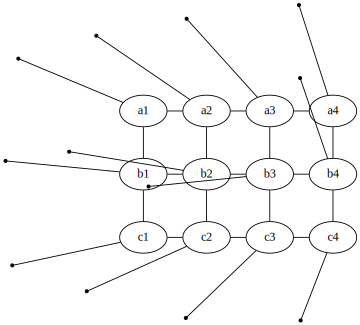

In [ ]:
graph, row_symbols = denoising_MRF(3, 4)
position_hints = {c:float(1-i) for i,c in enumerate(row_symbols)}
show(graph, binary_edges=True, hints=position_hints)

## A 2D Points Gaussian MRF

We create a grid of 2D points, connected in a 4-neighborhood, to show off clustered loopy belief propagation.

In [ ]:
#| export